In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [13]:
# Load your data as you were before
def load(file_path):
    df = pd.read_csv(file_path)
    m, s = df['tow'].mean(), df['tow'].std()
    df['date'] = pd.to_datetime(df['date'])
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    df['offblock_hour'] = df['actual_offblock_time'].dt.round('h').dt.hour
    df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
    df['offblock_month'] = df['actual_offblock_time'].dt.month
    df = df.drop(columns=['flight_id','name_adep', 'callsign', 'actual_offblock_time', 'arrival_time', 'date'])
    df['tow'] = (df['tow'] - m) / s  # Standardize 'tow' column
    return df, m, s

# Load data
df, mean, std = load('challenge_set.csv')


In [14]:
# Separate features and target
X = df.drop('tow', axis=1)
y = df['tow']


In [15]:
X = df.drop('tow', axis=1)
y = df.tow

In [16]:
# Handle categorical columns with Label Encoding
categorical_columns = ['adep', 'country_code_adep', 'ades', 'name_ades', 
                       'country_code_ades', 'aircraft_type', 'wtc', 'airline']


In [17]:
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Ensure all data is treated as string for encoding
    label_encoders[col] = le

In [18]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)


In [19]:
# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Max number of leaves in one tree
    'learning_rate': 0.05,  # Shrinkage rate
    'feature_fraction': 0.9,  # Feature sampling fraction
    'bagging_fraction': 0.8,  # Data sampling fraction
    'bagging_freq': 5,  # Bagging every 5 iterations
    'verbose': -1  # Suppress output
}


In [20]:
# Train the model with early stopping
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0858536	valid_1's rmse: 0.0864172


In [21]:
# Predict on validation set
y_pred = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)

# Calculate RMSE for validation set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 0.08641717855672111


In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'mean' and 'std' were used to normalize the 'tow' column
# and preds_val contains the model predictions on the validation set.

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Denormalize both the actual and predicted values (y_val and preds_val)
y_val_denormalized = y_val * std + mean
preds_val_denormalized = y_pred * std + mean

# Compute the RMSE
rmse = root_mean_squared_error(y_val_denormalized, preds_val_denormalized)

# Print the RMSE
print('Model validation RMSE: {:.4f}'.format(rmse))


Model validation RMSE: 4601.7942


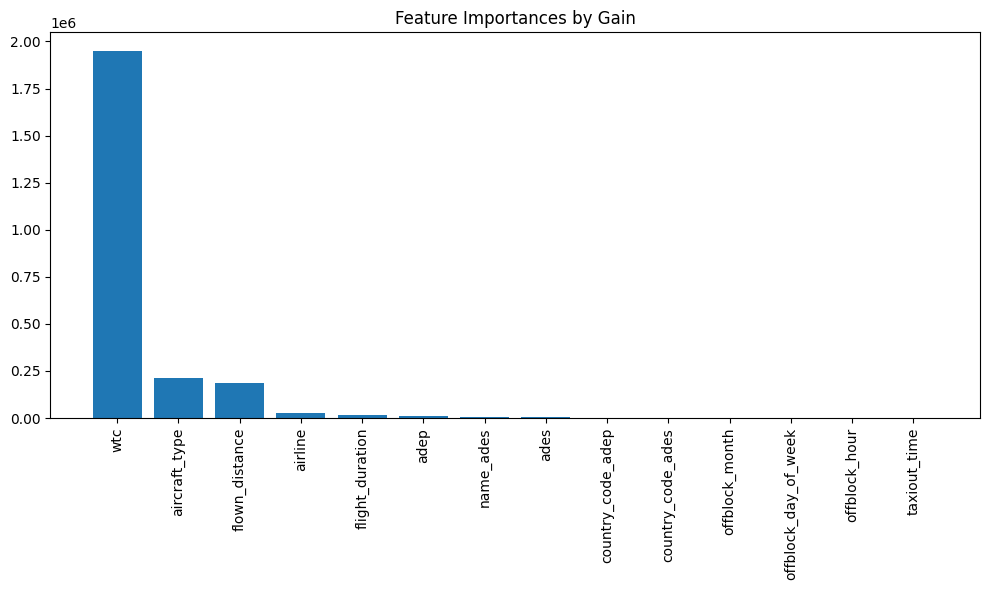

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

# Assuming lgbm_model is the trained LightGBM model

# Extract feature importances
importances = lgbm_model.feature_importance(importance_type='gain')  # 'split' for frequency, 'gain' for total gain
feature_names = X_train.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances by Gain")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## Hyperparameter Tunning


In [24]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# Set up the parameter grid
param_grid = {
    'num_leaves': [31, 50, 70, 100],  # Larger num_leaves can improve accuracy
    'max_depth': [-1, 10, 20, 30],  # Limit the tree depth for better generalization
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Lower values usually give better performance with longer training
    'n_estimators': [100, 500, 1000],  # Number of boosting iterations
    'min_data_in_leaf': [10, 20, 50],  # Minimum number of records a leaf may have
    'bagging_fraction': [0.7, 0.8, 0.9],  # Fraction of data to use for each iteration
    'feature_fraction': [0.7, 0.8, 0.9],  # Fraction of features to use for each iteration
    'lambda_l1': [0, 0.1, 0.5, 1],  # L1 regularization
    'lambda_l2': [0, 0.1, 0.5, 1]   # L2 regularization
}

# Create the LightGBM regressor
lgbm = lgb.LGBMRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lgbm,
                                   param_distributions=param_grid,
                                   n_iter=100,  # Number of random combinations to try
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,  # 5-fold cross-validation
                                   verbose=1,  # Output the process
                                   random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (RMSE): {abs(random_search.best_score_)}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'num_leaves': 100, 'n_estimators': 1000, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.2, 'lambda_l2': 0.1, 'lambda_l1': 1, 'feature_fraction': 0.8, 'bagging_fraction': 0.7}
Best score (RMSE): 0.06559860356063021


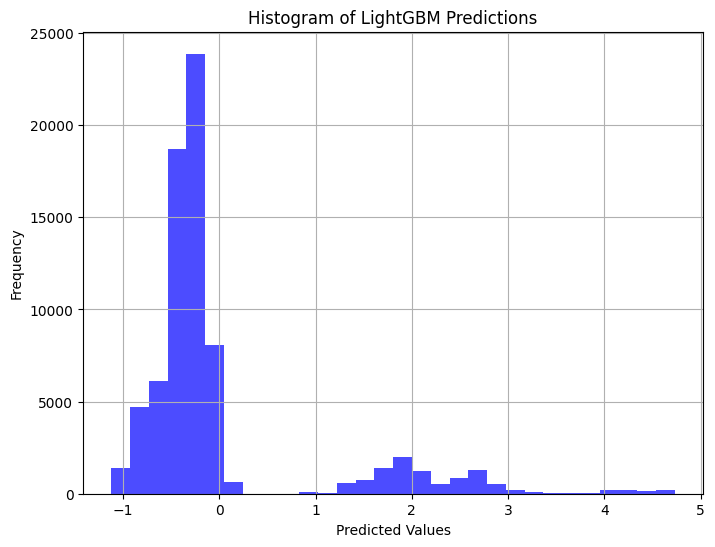

In [25]:
import matplotlib.pyplot as plt

# Assuming you have already made predictions
y_pred = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of LightGBM Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'mean' and 'std' were used to normalize the 'tow' column
# and preds_val contains the model predictions on the validation set.

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Denormalize both the actual and predicted values (y_val and preds_val)
y_val_denormalized = y_val * std + mean
preds_val_denormalized = y_pred * std + mean

# Compute the RMSE
rmse = root_mean_squared_error(y_val_denormalized, preds_val_denormalized)

# Print the RMSE
print('Model validation RMSE: {:.4f}'.format(rmse))


Model validation RMSE: 4601.7942


## SUBMISION

In [27]:
import numpy as np

# Function to extend the label encoder with new unseen labels
def extend_label_encoder(encoder, new_labels):
    """Extend the LabelEncoder to handle new labels in the test set."""
    current_classes = list(encoder.classes_)
    for label in new_labels:
        if label not in current_classes:
            current_classes.append(label)
    encoder.classes_ = np.array(sorted(current_classes))  # Keep classes sorted

# Loop through the categorical columns and extend the label encoders with unseen labels
for col in categorical_columns:
    if col in label_encoders:
        unseen_labels = set(X_test[col].unique()) - set(label_encoders[col].classes_)
        if unseen_labels:
            extend_label_encoder(label_encoders[col], unseen_labels)
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# Predict on the encoded test set
y_pred = lgbm_model.predict(X_test)

# Denormalize the predictions
y_test_denormalized = y_pred * std + mean

# Print the denormalized predictions
print("Denormalized Predictions (y_test):")
print(y_test_denormalized)


NameError: name 'X_test' is not defined

In [ ]:
import pandas as pd

# Assuming 'y_test_denormalized' contains the predictions and 'submission_set.csv' has the 'flight_id' column

# Load the test data to extract 'flight_id'
dft0 = pd.read_csv('submission_set.csv')

# Assign the denormalized predictions to the 'tow' column
dft0['tow'] = y_test_denormalized

# Save the flight_id and tow columns to a CSV file
dft0[['flight_id', 'tow']].to_csv('lightgbm.csv', index=False)

# Print a confirmation message
print("Predictions saved to 'lightgbm.csv'.")


In [ ]:
!head lightgbm.csv